In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test: a simple model

In [19]:
from hackaton_eet.data.loaders import get_data
from hackaton_eet.data.transformers import align_data

First, let's get the data. To maket his easier, a helper function `get_data` has been created. As inputs, this function expects a dictionary of your desired datasets, their columns and lags. Note that all lags are given in terms of 15 minutes, and the dates on the column are the day you are trying to predict.

Since we run the model each day at 10:00:00, this means that lag 1 is 09:45:00, and so on.

The code knows of each set which bits are known in advance and which parts are only known after the fact, and will only return the data you have available at each time. It is highly recommended to use this function instead of writing your own.

In [88]:
feature_datasets = {
    'tennet.verrekenprijzen': {
        'lags': [1, 2, 3, 4, 5, 7, 14],  # Lags are now days. Makes working with them easier
        'columns': ['invoeden', 'Afnemen']
    }
    ,
    'gen.gendemand.forecast' : {
        'lags': [1, 2, 3, 4, 5, 7, 14],
        'columns': ['h2qt_forecast_demand']
    },
    'pricehub.pricehub': {
        'lags': [1, 2, 3, 4, 5, 7, 14],
        'columns': ['EEXSPOT', 'PNSPOT', 'APXSPOT', 'BPXSPOT',
                    'EEXCHSPOT', 'N2EXSPOT', 'TTF', 'EUA',
                    'SPARK_NL', 'APIEUR', 'DARK_DE']
    }
}

target_dataset = {
    'tennet.target': {
        'columns': ['invoeden', 'Afnemen'],
        'lags': [1]
    }
}

feature_data = get_data(feature_datasets)
target_data = get_data(target_dataset)

In [87]:
features = feature_data.T

con_cols = ['reuters.dayahead.CON_NLD.lag_1',
            'reuters.dayahead.CON_NLD.lag_2',
            'reuters.dayahead.CON_NLD.lag_3',
            'reuters.dayahead.CON_NLD.lag_7']

wind_cols = ['reuters.dayahead.Wind_NLD.lag_1',
             'reuters.dayahead.Wind_NLD.lag_2',
             'reuters.dayahead.Wind_NLD.lag_3',
             'reuters.dayahead.Wind_NLD.lag_7']

for con_col in con_cols:
    for wind_col in wind_cols:
        diff_col = 'con_wind_diff.lag_' + con_col[-1:]
        ratio_col = 'con_wind_ratio.lag_' + con_col[-1:]
        features[diff_col] = features[con_col] - features[wind_col]

KeyError: 'reuters.dayahead.CON_NLD.lag_1'

In [ ]:
features = features.drop(['reuters.dayahead.CON_NLD.lag_1',
               'reuters.dayahead.CON_NLD.lag_2',
               'reuters.dayahead.CON_NLD.lag_3',
               'reuters.dayahead.CON_NLD.lag_7',
               'reuters.dayahead.Wind_NLD.lag_1',
               'reuters.dayahead.Wind_NLD.lag_2',
               'reuters.dayahead.Wind_NLD.lag_3',
               'reuters.dayahead.Wind_NLD.lag_7'], axis=1)

In [63]:
feature_data = features.T

## Training the model

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, explained_variance_score

In [82]:
s = 24*4*400

In [89]:
X = feature_data.fillna(0).values
y = target_data.fillna(0).values

X, y = align_data(X, y)

X, y = X.T, y.T

X_train, X_test = X[:s], X[s:]
y_train, y_test = y[:s], y[s:]

In [90]:
model = LinearRegression()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [91]:
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print("VAF: %.2f" % explained_variance_score(y_test, y_pred))

MAE: 31.10
VAF: 0.08


In [71]:
est = RandomForestRegressor(
    n_estimators=200,
    max_depth=3,
    n_jobs=-1,
)
est = est.fit(X_train, y_train)
y_pred = est.predict(X_test)

In [72]:
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print("VAF: %.2f" % explained_variance_score(y_test, y_pred))

MAE: 34.78
VAF: 0.05


So, did it work?

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

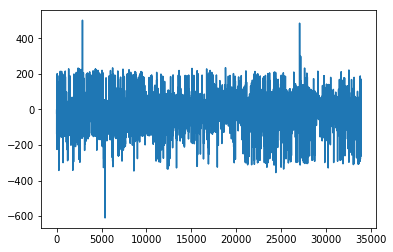

In [70]:
plt.plot(y_pred[:, 1] - y_test[:, 1])